In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, math
from scipy import stats
import os

# Scale factor vs shuffle amount

In [104]:
shuffle_amount = 80.0
scale_factor = 1.0

def load_network_errors(shuffle_amount, scale_factor):
    randoms = np.arange(10)
    errors = []
    for random in randoms:
        filename = f"hdreshufflerelCTRNN_2DIR1O_dr100_n0.1_la0_sa{shuffle_amount:1}_sf{scale_factor:1}_dp0.5_r{random}"
        filename = f"data_json/{filename}.json"
        if os.path.isfile(filename):
            with open(filename) as f: info = json.load(f)
            errors.append(info["errors_last"][2])
    return np.array(errors)

In [105]:
shuffle_amounts = np.arange(0, 161, 10, dtype="float")
scale_factors = np.arange(1, 5.1, 0.25, dtype="float")
error_means = np.zeros((len(shuffle_amounts), len(scale_factors)), "float")

for i, shuffle_amount in enumerate(shuffle_amounts):
    for j, scale_factor in enumerate(scale_factors):
        error_means[i, j] = np.mean(load_network_errors(shuffle_amount, scale_factor))

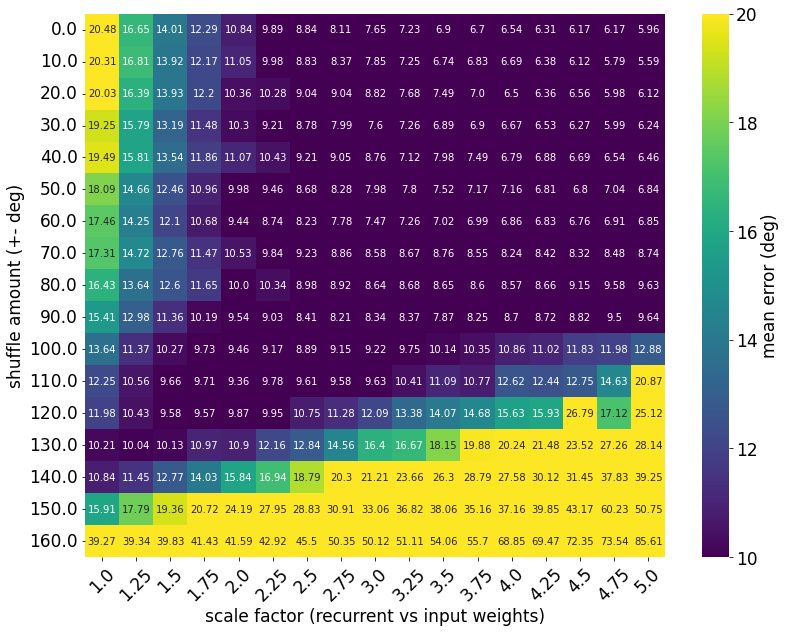

In [107]:
fig = plt.figure(figsize=(13, 10))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ax = sns.heatmap(error_means, cmap="viridis", annot=((error_means*100).astype(int)/100).astype(str), annot_kws={'fontsize': 10}, fmt='s', vmin=10, vmax=20, cbar_kws={'label': 'mean error (deg)'})
ax.set_xticklabels(scale_factors, rotation=45)
ax.set_yticklabels(shuffle_amounts, rotation=0)
ax.set_xlabel("scale factor (recurrent vs input weights)")
ax.set_ylabel("shuffle amount (+- deg)")
plt.show()

# Structural vs Functional Connectivity

In [ ]:
shuffle_amount = 80.0
scale_factor = 1.0

def load_network_errors(shuffle_amount, scale_factor):
    randoms = [0, 1, 2, 3, 4]
    errors = []
    for random in randoms:
        filename = f"hdreshufflerelCTRNN_2DIR1O_dr100_n0.1_la0_sa{shuffle_amount:1}_sf{scale_factor:1}_r{random}_dv"
        with open(f"data_json/{filename}.json") as f: info = json.load(f)
        errors.append(info["error_final"][2])
    return np.array(errors)